In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import random
import struct
import subprocess
import sys
from matplotlib.patches import Rectangle

In [2]:
base_dir = os.getcwd()
exec_dir = '..'

In [3]:
# Returns all records whose location is in the given range.
def range_query(df, lx, ly, ux, uy):
    return (df[(df.ACCLOC_X >= lx) & (df.ACCLOC_X <= ux) & 
              (df.ACCLOC_Y >= ly) & (df.ACCLOC_Y <= uy)])

# Returns the bounding rectangle of a Pandas dataframe.
def bounding_rect(df):
    return (np.min(df['ACCLOC_X']), np.min(df['ACCLOC_Y']), 
            np.max(df['ACCLOC_X']), np.max(df['ACCLOC_Y']))

# Generates a random rectangle inside the given interval.
def random_rect(lx, ly, ux, uy):
    # Generate a random lower-left vertex.
    px = random.uniform(lx, ux)
    py = random.uniform(ly, uy)
    width = random.uniform(0, ux-px)
    height = random.uniform(0, uy-py)
    return (px, py, px+width, py+height)

def to_string(rect):
    return '({}, {}, {}, {})'.format(rect[0],rect[1],rect[2],rect[3])

In [4]:
df = pd.read_csv('data/crash_data.csv')
df.head()

,REPORT_ID,Year,Month,Day,Time,ACCLOC_X,ACCLOC_Y
0,2012-1-27/05/2021,2012,January,Sunday,04:30 pm,1330659.71,1671795.87
1,2012-2-27/05/2021,2012,January,Sunday,09:10 am,1329400.16,1668462.66
2,2012-3-27/05/2021,2012,January,Wednesday,11:30 am,1313748.22,1624241.28
3,2012-4-27/05/2021,2012,January,Wednesday,10:20 am,1325326.77,1672425.55
4,2012-5-27/05/2021,2012,January,Wednesday,03:30 pm,1326056.45,1673028.42


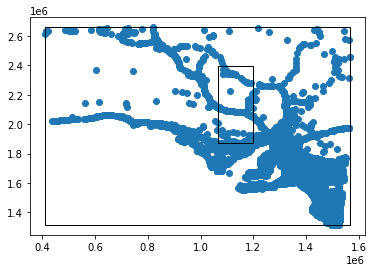

In [5]:
r = bounding_rect(df)
q = random_rect(r[0],r[1],r[2],r[3])
plt.scatter(df['ACCLOC_X'], df['ACCLOC_Y'])
plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))
plt.gca().add_patch(Rectangle((q[0], q[1]), q[2]-q[0], q[3]-q[1], fill=None, alpha=1))

# Query generation

First experiment: generate random queries. We construct a data set of $2 \times 10^5$ random queries and measure the number of records that satisfy them.

Then we consider fractions from 10% to 90%. For each fraction we select 50 queries with that fraction and create separate data sets.

In [6]:
def queries_with_fraction(df, fmin, fmax):
    return (df[(df.fraction >= fmin) & (df.fraction <= fmax)]).sort_values('fraction')

In [7]:
query_df = pd.read_csv('data/random_queries.csv')
for i in range(1, 10):
    size = len(queries_with_fraction(query_df, i/10-0.01, i/10+0.01))
    print('Fraction: {}%\tQueries: {}'.format(i*10, size))

Fraction: 10%	Queries: 1608
Fraction: 20%	Queries: 731
Fraction: 30%	Queries: 437
Fraction: 40%	Queries: 369
Fraction: 50%	Queries: 326
Fraction: 60%	Queries: 356
Fraction: 70%	Queries: 546
Fraction: 80%	Queries: 990
Fraction: 90%	Queries: 6793


In [8]:
sampled_queries_per_fraction = 100
for i in range(1, 10):
    q_part = queries_with_fraction(query_df, i/10-0.01, i/10+0.01)
    q_part = q_part.sample(n=sampled_queries_per_fraction)
    q_part.to_csv('data/random_queries_{}.csv'.format(i*10), index=False)
print('Done!')

Done!


# Fraction of records (10%-90%)

In [7]:
m=30000
c=16
input_file = '{}/data/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_query_verification/test_fraction.csv'.format(base_dir)

In [10]:
f = open(output_file, 'w')
f.write('fraction,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for i in range(1, 10):
    query_file = '{}/data/random_queries_{}.csv'.format(base_dir, i*10)
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{}%,{},{},{},{}\n'.format(i*10,avg_retur,avg_match,avg_query,avg_verif))
    
f.close()

os.chdir(base_dir)
print('Done!')

Done!


In [6]:
df=pd.read_csv('test_query_verification/test_fraction.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'avg_returned': int, 'avg_matching': int})
df['noise'] = (df['avg_returned']-df['avg_matching'])/30000 #(df['avg_matching'])
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'noise':3, 'avg_query': 3, 'avg_verif': 3})
# Reorder columns.
df = df[['fraction','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 fraction &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
       10 &         17476 &          2984 &  0.483 &      4.470 &     16.786 \\
       20 &         19614 &          6007 &  0.454 &      3.485 &     20.571 \\
       30 &         18866 &          9000 &  0.329 &      3.261 &     23.135 \\
       40 &         20472 &         12022 &  0.282 &      3.243 &     23.023 \\
       50 &         22485 &         14993 &  0.250 &      3.626 &     27.298 \\
       60 &         23772 &         18027 &  0.192 &      3.778 &     30.627 \\
       70 &         25004 &         20980 &  0.134 &      4.026 &     33.679 \\
       80 &         27048 &         23991 &  0.102 &      4.348 &     37.622 \\
       90 &         28030 &         27030 &  0.033 &      4.864 &     44.459 \\
\bottomrule
\end{tabular}



# Low fractions (1%-9%)

In [27]:
sampled_queries_per_fraction = 40
query_df = pd.read_csv('data/random_queries.csv')
for i in range(1, 10):
    q_part = queries_with_fraction(query_df, i/100-0.001, i/100+0.001)
    q_part = q_part.sample(n=sampled_queries_per_fraction)
    q_part.to_csv('data/random_queries_{}.csv'.format(i), index=False)
print('Done!')

Done!


In [28]:
m=30000
c=16
input_file = '{}/data/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_query_verification/test_fraction_low.csv'.format(base_dir)

In [29]:
f = open(output_file, 'w')
f.write('fraction,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for i in range(1, 10):
    query_file = '{}/data/random_queries_{}.csv'.format(base_dir, i)
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{},{},{},{},{}\n'.format(i,avg_retur,avg_match,avg_query,avg_verif))
    
f.close()

os.chdir(base_dir)
print('Done!')

Done!


In [30]:
df=pd.read_csv('test_query_verification/test_fraction_low.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'avg_returned': int, 'avg_matching': int})
df['noise'] = (df['avg_returned']-df['avg_matching'])/30000 #(df['avg_matching'])
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'noise':3, 'avg_query': 3, 'avg_verif': 3})
# Reorder columns.
df = df[['fraction','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 fraction &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
        1 &          4038 &           301 &  0.125 &      0.568 &      2.651 \\
        2 &          6631 &           597 &  0.201 &      0.938 &      4.315 \\
        3 &         10648 &           894 &  0.325 &      1.683 &      7.238 \\
        4 &          9760 &          1197 &  0.285 &      1.421 &      6.659 \\
        5 &         13759 &          1498 &  0.409 &      2.247 &     10.096 \\
        6 &         16219 &          1796 &  0.481 &      2.766 &     12.250 \\
        7 &         16789 &          2098 &  0.490 &      2.707 &     12.463 \\
        8 &         18015 &          2400 &  0.520 &      2.936 &     13.572 \\
        9 &         16767 &          2701 &  0.469 &      2.533 &     12.452 \\
\bottomrule
\end{tabular}



# Capacity

Our second analysis was aimed at studying 
how the page capacity impacts on the execution times
of query and verification algorithms. 
For this reason, we chose a data set with 
$m = 2 \times 10^4$ records, a query $Q$
with a fraction $f_Q = 20\%$ and then constructed
several MR-trees with different page capacities.
For each tree, we executed the query and verification
algorithms 20 times and computed an average of
their running times. 

In [11]:
m=20000
capacities=[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 250, 500, 750, 1000]
n_trials=20
input_file = '{}/test_query_verification/crash_data_{}.csv'.format(base_dir, m)
output_file = '{}/test_query_verification/test_capacity.csv'.format(base_dir)
test_df = pd.read_csv(input_file)
query_df = pd.read_csv('./test_query_verification/queries_capacity.csv')
query_id = 4859
q = query_df.loc[4859]

f = open(output_file, 'w')
f.write('capacity,returned,matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for c in capacities:
    # Run the C++ implementation.
    print('Testing capacity = {}...'.format(c))
    avg_query, avg_verif, returned_rec, matching_rec = 0, 0, 0, 0
    for i in range(0, n_trials):
        params = ['./TestQuery', input_file, str(c), str(q.lx), str(q.ly), str(q.ux), str(q.uy)]
        p = subprocess.run(params, capture_output=True, check=True)
        lines = p.stdout.decode('utf-8').splitlines()
        returned_rec += int((lines[2].split(':'))[1])
        matching_rec += int((lines[3].split(':'))[1])
        avg_query += int((lines[4].split(':'))[1])
        avg_verif += int((lines[5].split(':'))[1])
    returned_rec /= n_trials 
    matching_rec /= n_trials
    avg_query /= n_trials
    avg_verif /= n_trials
    f.write('{},{},{},{},{}\n'.format(c,returned_rec,matching_rec,avg_query,avg_verif))

f.close()

os.chdir(base_dir)
print('Done!')

Testing capacity = 5...
Testing capacity = 10...
Testing capacity = 20...
Testing capacity = 30...
Testing capacity = 40...
Testing capacity = 50...
Testing capacity = 60...
Testing capacity = 70...
Testing capacity = 80...
Testing capacity = 90...
Testing capacity = 100...
Testing capacity = 250...
Testing capacity = 500...
Testing capacity = 750...
Testing capacity = 1000...
Done!


In [14]:
df=pd.read_csv('./test_query_verification/test_capacity.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'returned': int, 'matching': int})
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'avg_query': 3, 'avg_verif': 3})
print(df.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 capacity &  returned &  matching &  avg\_query &  avg\_verif \\
\midrule
        5 &      4175 &      4120 &      0.755 &     10.075 \\
       10 &      4300 &      4120 &      0.469 &      6.412 \\
       20 &      4800 &      4120 &      0.404 &      5.411 \\
       30 &      5400 &      4120 &      0.386 &      4.625 \\
       40 &      4800 &      4120 &      0.296 &      4.240 \\
       50 &      7500 &      4120 &      0.482 &      5.124 \\
       60 &      5600 &      4120 &      0.368 &      4.180 \\
       70 &      4900 &      4120 &      0.305 &      3.732 \\
       80 &      6400 &      4120 &      0.427 &      4.382 \\
       90 &     11900 &      4120 &      0.732 &      6.818 \\
      100 &     10000 &      4120 &      0.731 &      5.728 \\
      250 &     20000 &      4120 &      1.314 &      9.026 \\
      500 &     20000 &      4120 &      1.790 &      9.496 \\
      750 &     20000 &      4120 &      1.566 &      9.597 \\
     1000 & 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


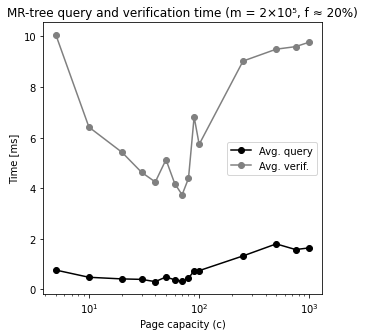

In [22]:
plt.figure(figsize=(5, 5))
plt.title("MR-tree query and verification time (m = 2×10⁵, f ≈ 20%)")
plt.xticks(df['capacity'])
plt.xscale('log')
plt.plot(df['capacity'], df['avg_query'], marker='o', color='black', label='Avg. query')
plt.plot(df['capacity'], df['avg_verif'], marker='o', color='grey', label='Avg. verif.')
#plt.axvline(75, 0, 1, color='gray', linestyle='--')
plt.ylabel("Time [ms]")
plt.xlabel("Page capacity (c)")
plt.legend()
plt.savefig("test_query_verification/test-capacity.eps", format='eps', bbox_inches='tight')